# 目標： 調查在PTT政黑版最近100篇文章以及推文中，出現頻率最高的20個詞彙

同時也調查最常發文/留言的id / ip -> 判斷是否有網軍想要導風向

In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# PTT 八卦版網址
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index.html'
PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
def crawl_article(url):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()
            
            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]
                
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime})
        
        #comments.append(messages)
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        #'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count,
        'messages': messages
    }

    return data, messages

In [3]:
def crawl_comment(amount=50):

    all_data = []
    comments = []
    counter = 0
    nextPage = PTT_URL

    while counter <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                #如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(all_data) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data, comments
                
                # 呼叫上面寫好的 function 來對文章進行爬蟲
                parse_data, parse_comment = crawl_article(article_URL)
                #parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))
                
                '''
                if counter > amount:
                    time.sleep(2)
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data
                '''

                # 將爬完的資料儲存
                all_data.append(parse_data)
                comments.extend(parse_comment)
                
                counter += 1

    return all_data, comments

In [4]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [5]:
def getStopWord():
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [6]:
def jiebaWord(content, topk=20):
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list2 = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list2)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list2.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    

In [7]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    font_path = 'hi.ttf'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [8]:
def splitMessage(data):
    message_info = list()

    for row in data:

        messages = row['messages']
        if messages:
            for message in messages:
                message_info.extend(messages)
    
    message_info = list(set(message_info))
    
    return message_info

In [9]:
def jiebaCount(data, columnName, isData = True, topK = 20):
    all_content = ''
    
    if isData:
        for d in data:
            all_content += d[columnName]

        content_pd, content_tags = jiebaWord(all_content, topK)
    else:
        for val in data:
            if val:
                values = [d[columnName] for d in val]
                all_content += ''.join(values)
        content_pd, content_tags = jiebaWord(all_content, topK)
    
    return content_pd, content_tags

In [10]:
data, comments = crawl_comment(100)
save_data(data)

Parse [黑特] 有鄉民堅持台灣價值，非國產疫苗不打的 - https://www.ptt.cc/bbs/HatePolitics/M.1622702761.A.5A3.html
Parse [討論] 各位年輕人請注意 - https://www.ptt.cc/bbs/HatePolitics/M.1622702787.A.F18.html
Parse [黑特]請拿出AZ、莫德納原廠授權書 - https://www.ptt.cc/bbs/HatePolitics/M.1622702950.A.246.html
Reach the last article of this page
Parse Re: [討論] 卡管當台大校長對DPP到底有什麼好處？ - https://www.ptt.cc/bbs/HatePolitics/M.1622701800.A.8D2.html
Parse [新聞] 年輕人染疫比例增至25.2%！陳時中嘆：防 - https://www.ptt.cc/bbs/HatePolitics/M.1622701858.A.0D4.html
Parse [討論] 我們離四級愈來愈遠了 - https://www.ptt.cc/bbs/HatePolitics/M.1622701886.A.704.html
Parse [討論] 所以中央現在有再繼續談新的疫苗嗎 - https://www.ptt.cc/bbs/HatePolitics/M.1622701973.A.48F.html
Parse [黑特] 不上班他媽國家養嗎 - https://www.ptt.cc/bbs/HatePolitics/M.1622702012.A.FB4.html
Parse [新聞] 北台最大魚市場崁仔頂人擠人 林右昌：將 - https://www.ptt.cc/bbs/HatePolitics/M.1622702038.A.6D8.html
Parse [黑特] 對不起我的黨 我年輕 我賤我鬆懈！ - https://www.ptt.cc/bbs/HatePolitics/M.1622702245.A.A27.html
Parse Re: [新聞] 年輕人染疫比例增至25.2%！陳時中嘆：防 - https://www.ptt.cc/bbs/HatePoli

Parse [討論]  覺青還不打爆國產 - https://www.ptt.cc/bbs/HatePolitics/M.1622695803.A.DF9.html
Parse Re: [討論] 杯葛郭董買疫苗對民進黨到底有啥好處? - https://www.ptt.cc/bbs/HatePolitics/M.1622695965.A.104.html
Parse [討論] 俄羅斯疫苗 Sputnik V  台灣敢嘗試嗎？ - https://www.ptt.cc/bbs/HatePolitics/M.1622695970.A.469.html
Parse [討論] 親美人士和親中人士 高下立判 - https://www.ptt.cc/bbs/HatePolitics/M.1622695998.A.574.html
Parse [討論] 問一下喔 很多推文都會加"叭叭" 啥意思？ - https://www.ptt.cc/bbs/HatePolitics/M.1622696043.A.87C.html
Parse Re: [討論] 日本AZ，中國科興，台灣高端你會選？ - https://www.ptt.cc/bbs/HatePolitics/M.1622696046.A.894.html
Parse Re: [爆卦]蔡丁貴打完BNT，要大家當國產疫苗義勇軍 - https://www.ptt.cc/bbs/HatePolitics/M.1622696191.A.B54.html
Parse [討論] 既然3+11沒問題，為什麼不敢拿紀錄出來? - https://www.ptt.cc/bbs/HatePolitics/M.1622696284.A.FF3.html
Parse [討論] 如果真的拿到日本的AZ，會去打嗎？ - https://www.ptt.cc/bbs/HatePolitics/M.1622696596.A.D7F.html
Parse [討論] 陳時中要的授權書到底是甚麼鬼? - https://www.ptt.cc/bbs/HatePolitics/M.1622696601.A.07A.html
Parse [討論] 大老開示bnt是安全的還在擋什麼 - https://www.ptt.cc/bbs/HatePolitics/M.1622

In [11]:
content_pd, content_tags = jiebaCount(data, 'article_content', 10)

Building prefix dict from /Users/GaryWu/Desktop/Gary/OnlineCourse/Curop/Web_Crawler/Final/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.u9ec0ebec32d5ddd76c81146574223fdc.cache
Loading model cost 1.386 seconds.
Prefix dict has been built successfully.


# 在文章內容中，最常出現的20個詞彙

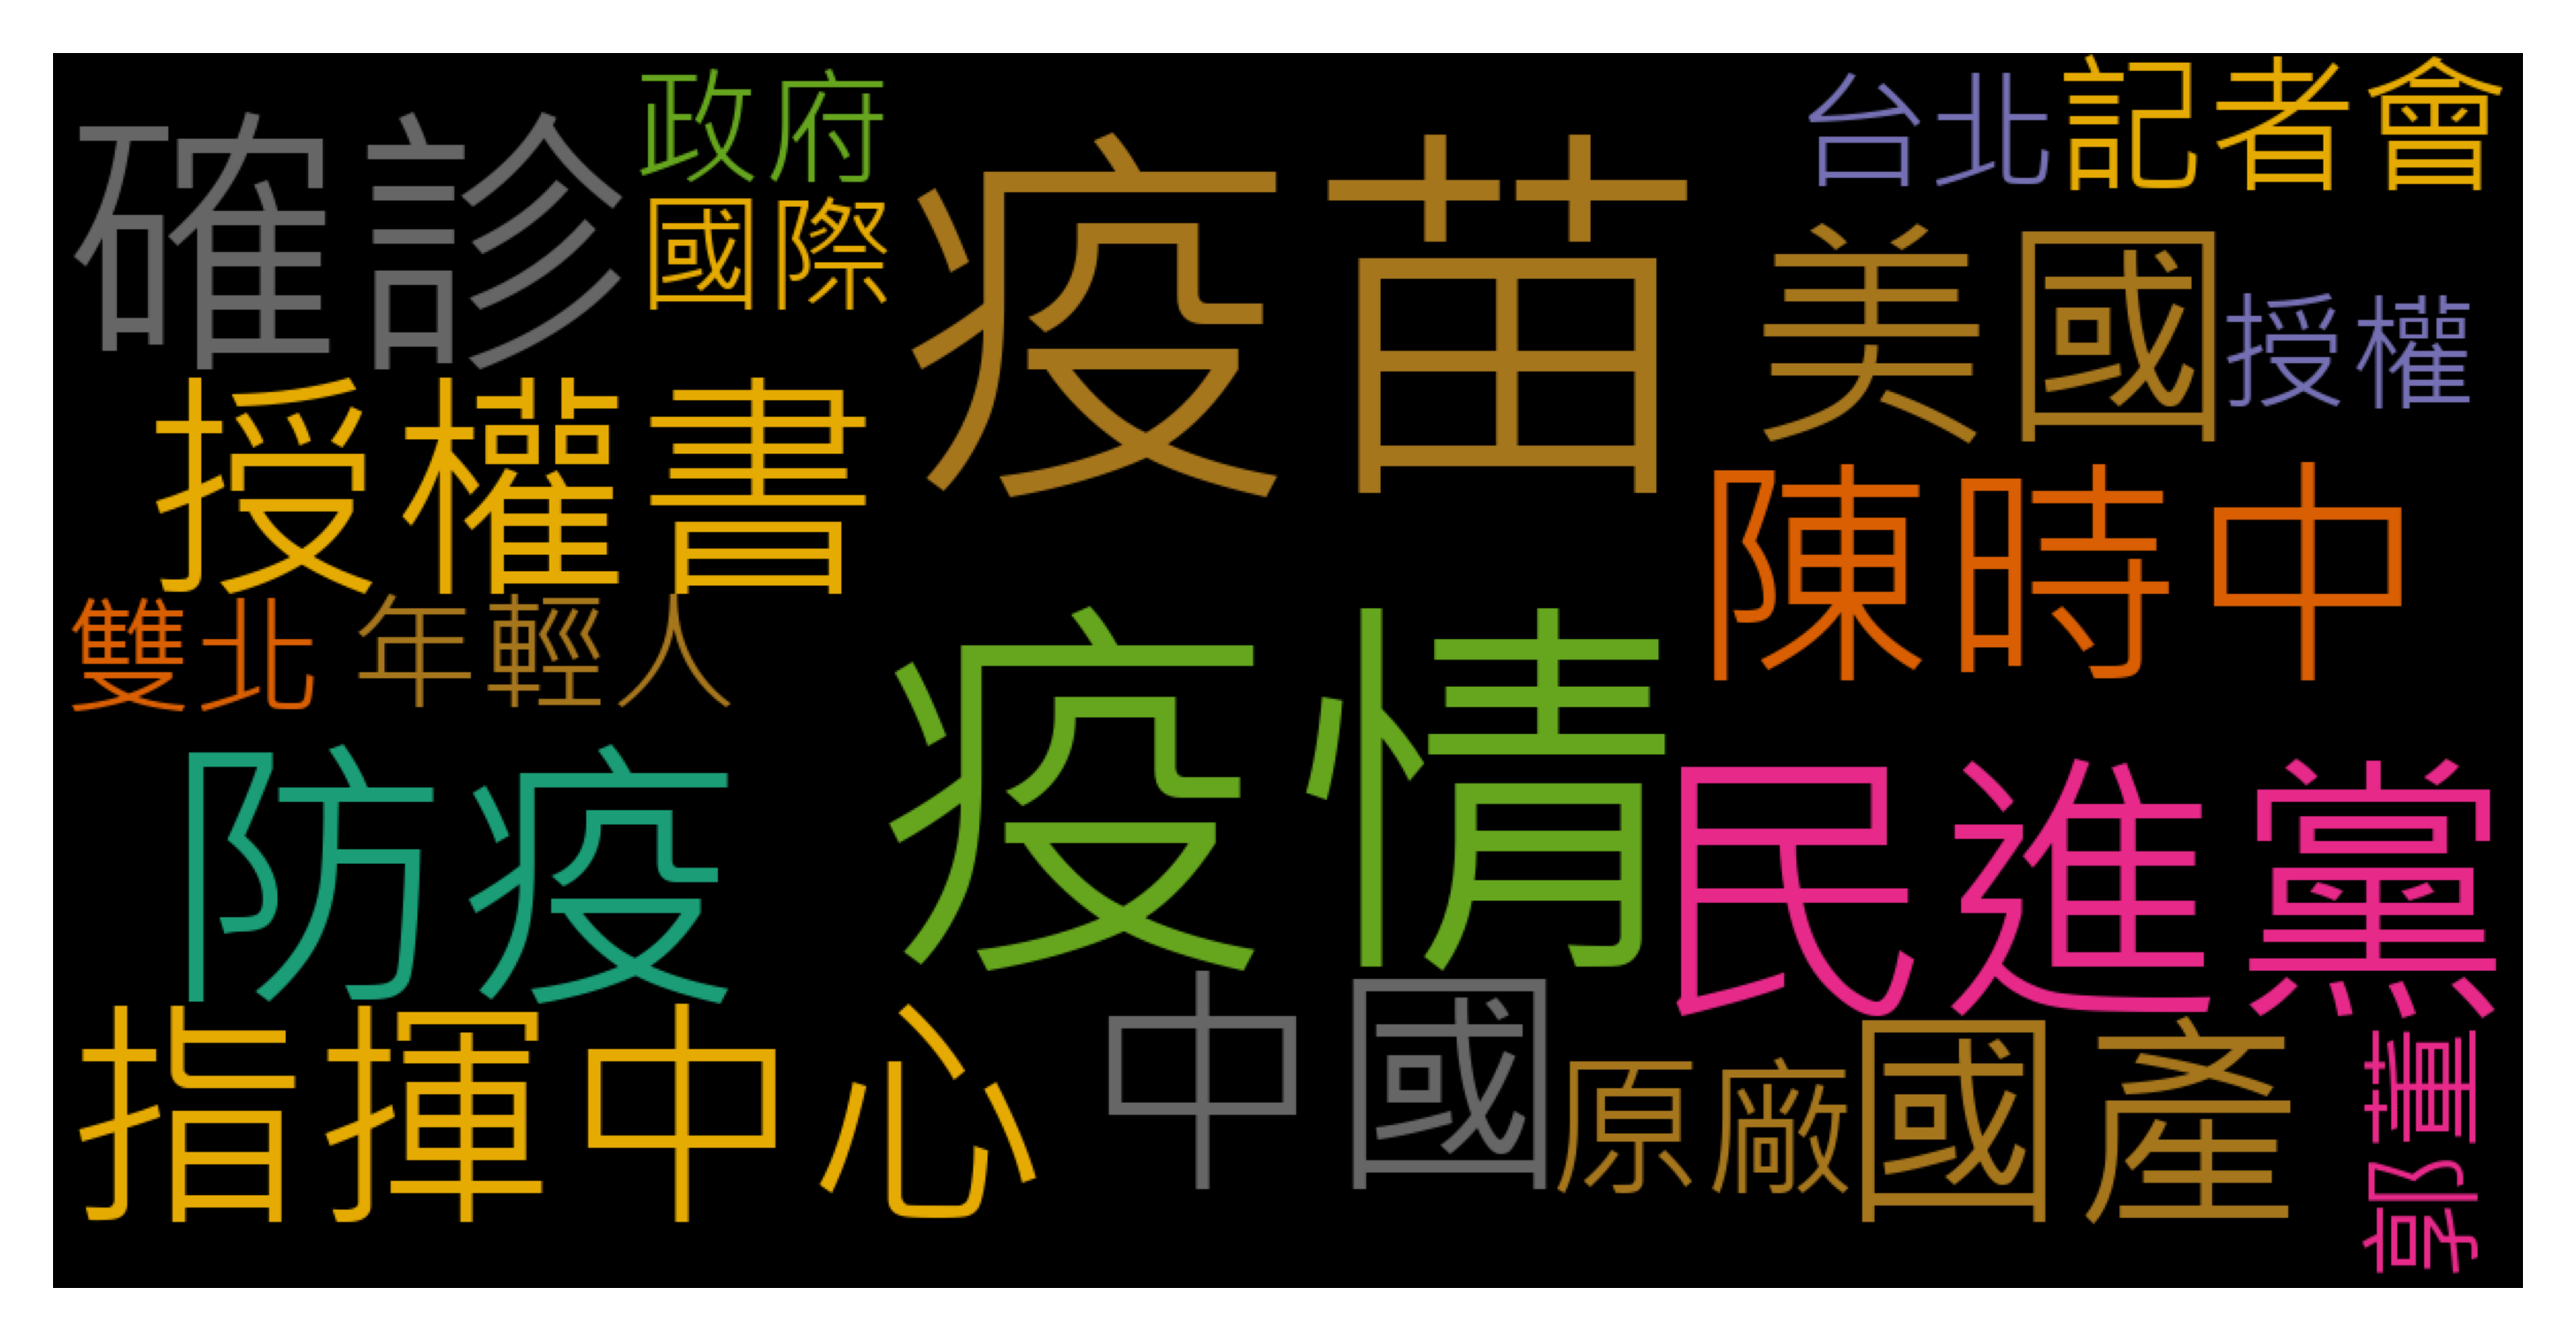

In [12]:
wordcloudPTT(content_tags)

# 在文章內容中，出現頻率最高的詞彙及其出現次數
# 從中可以發現，在發文內容中，出現最多次數的詞彙為疫苗 249次
# 其次是疫情，出現了70次

In [13]:
content_pd.sort_values(by=['Times'], ascending = False)

,KeyWords,Times
0,疫苗,249
1,疫情,70
15,政府,64
3,防疫,52
2,民進黨,45
4,確診,37
6,美國,37
5,指揮中心,36
7,陳時中,32
8,授權書,31


In [14]:
comments[1]

{'push_tag': '→',
 'push_userid': 'MoWilliams',
 'push_content': '年輕人真的可憐',
 'push_ipdatetime': '06/03 14:31'}

In [15]:
message_pd, message_tags = jiebaCount(comments, 'push_content', True, 40)

Building prefix dict from /Users/GaryWu/Desktop/Gary/OnlineCourse/Curop/Web_Crawler/Final/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.u9ec0ebec32d5ddd76c81146574223fdc.cache
Loading model cost 2.197 seconds.
Prefix dict has been built successfully.


# 在推文中，最常出現的20個詞彙

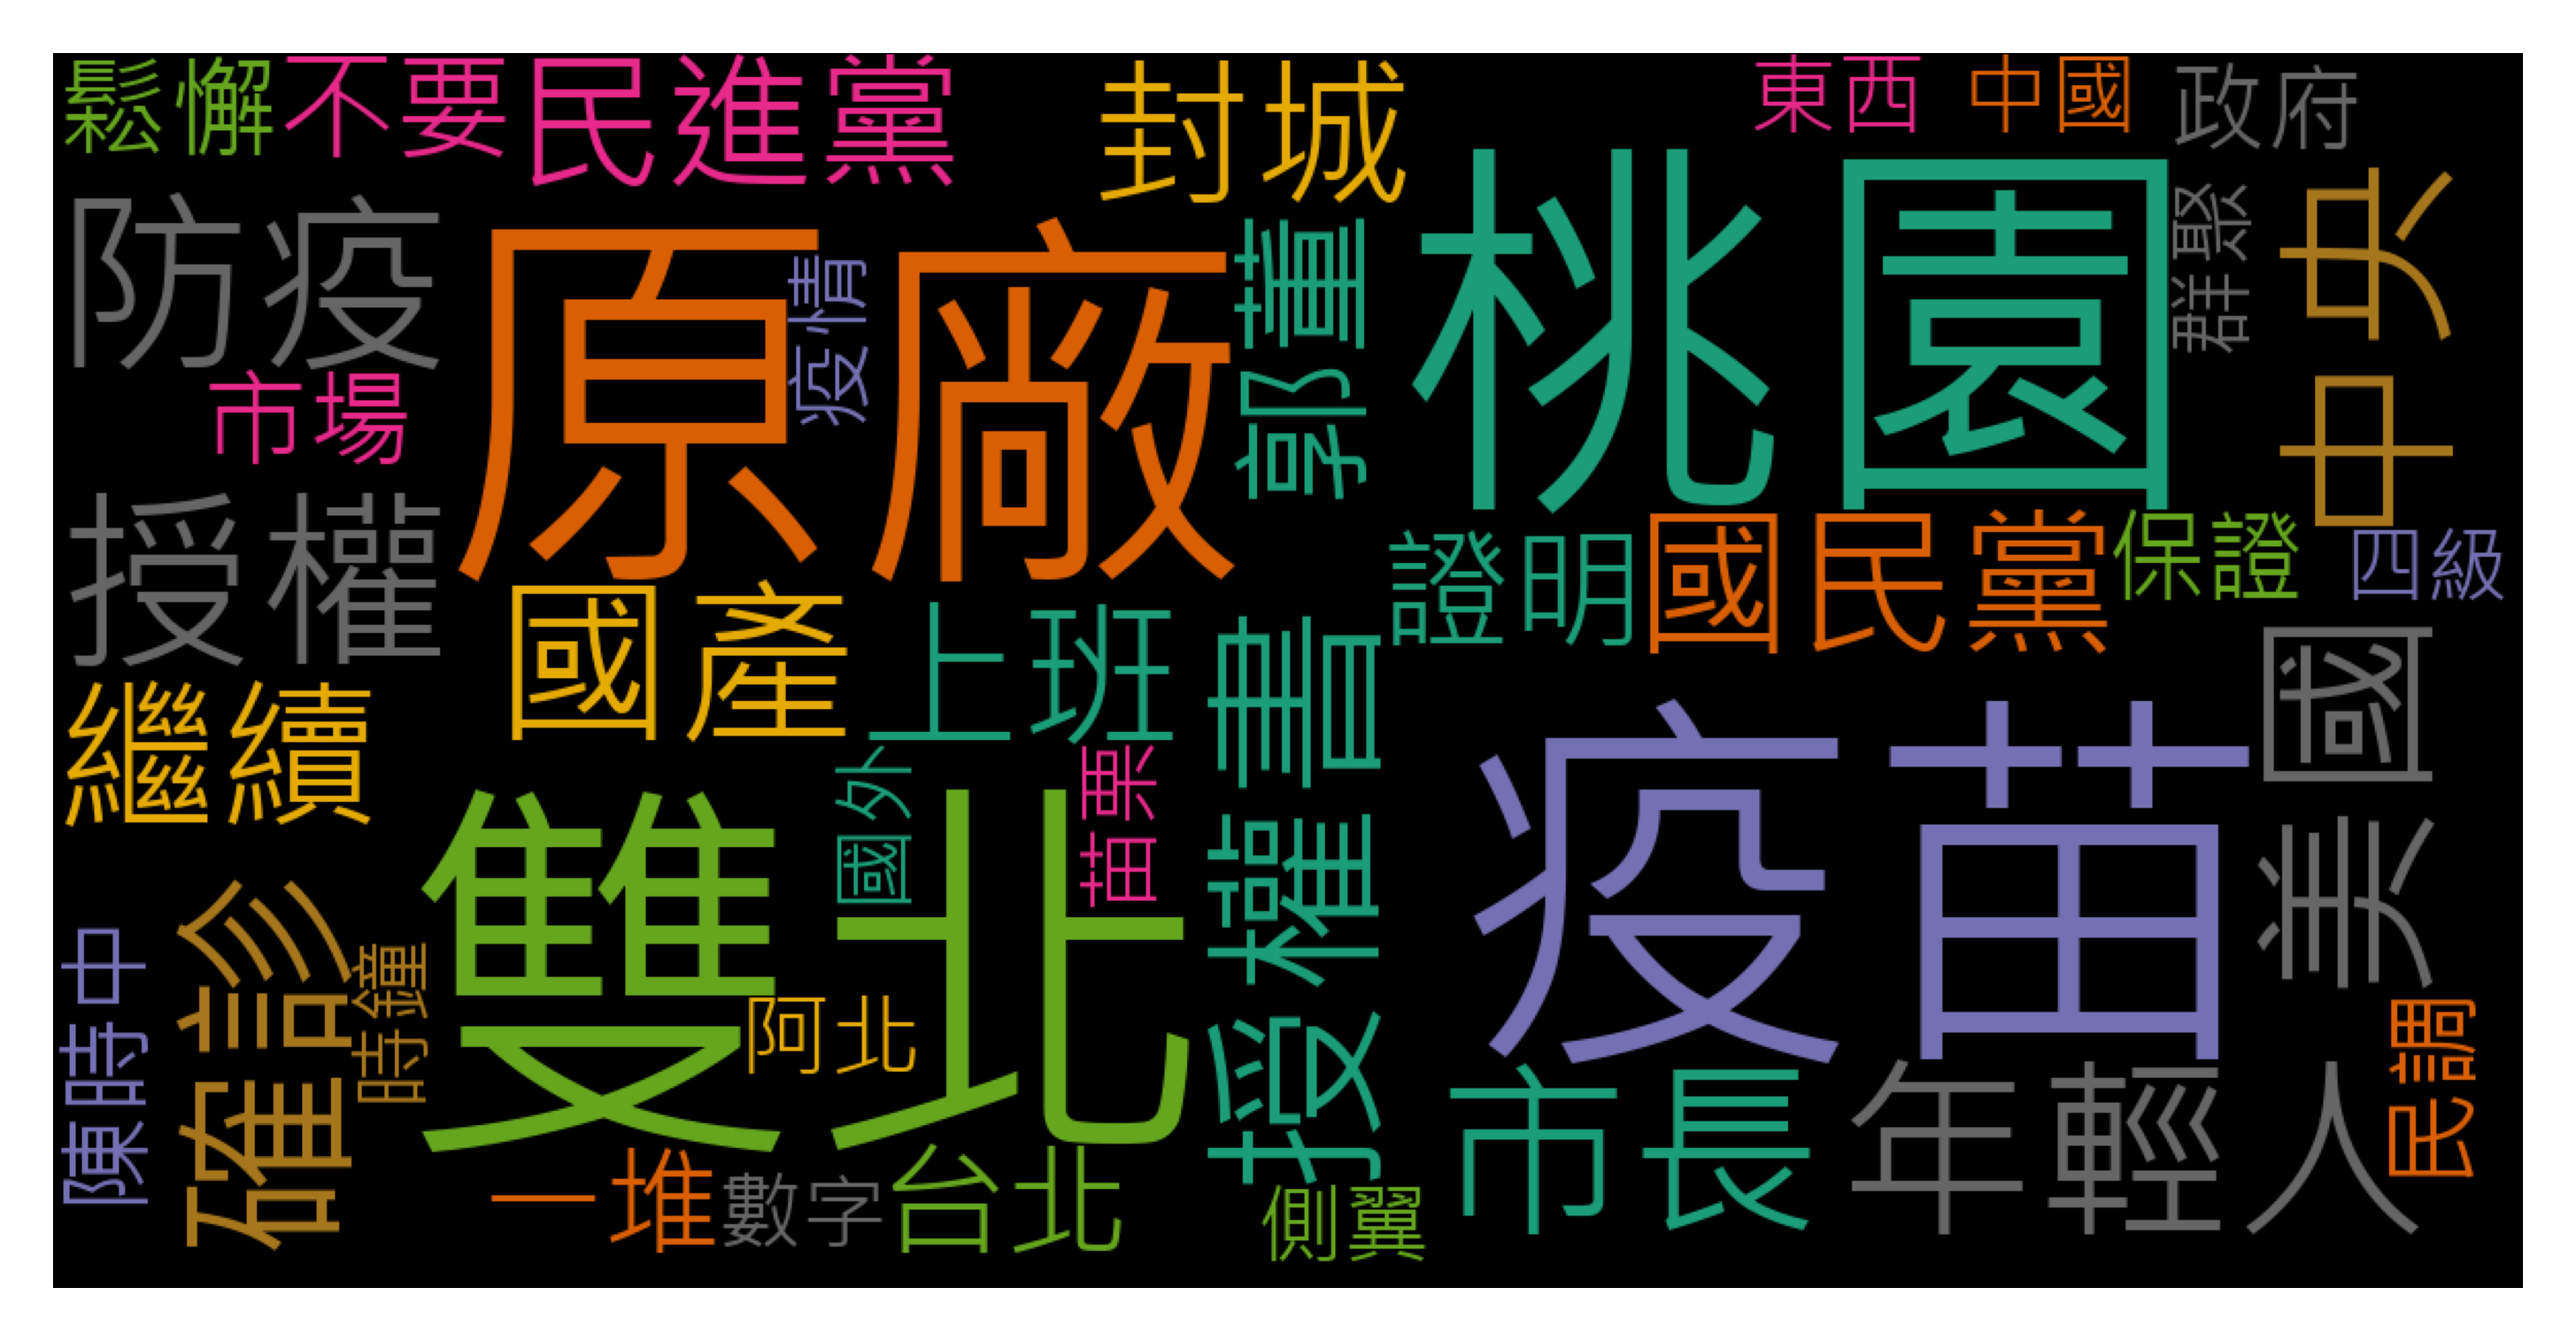

In [16]:
wordcloudPTT(message_tags)

# 在留言之中，出現最多次的詞彙也是疫苗，共249次

# 其次為雙北，出現114次

In [27]:
message_pd.sort_values(by=['Times'], ascending = False)

,KeyWords,Times
0,疫苗,245
1,雙北,114
8,中央,91
2,原廠,81
3,桃園,77
4,年輕人,75
22,不要,67
28,政府,63
6,防疫,55
15,上班,50


In [17]:
commentpd = pd.DataFrame(comments)
commentpd.head(100)

,push_tag,push_userid,push_content,push_ipdatetime
0,→,FrankChaung,哲哥？呵呵,06/03 14:31
1,→,MoWilliams,年輕人真的可憐,06/03 14:31
2,噓,nuclear,都是they的錯,06/03 14:31
3,→,rain0212,你發個幾十萬給我我就可以不用出門上班了,06/03 14:31
4,噓,chen31502,鬆你個頭 上班啦,06/03 14:31
...,...,...,...,...
95,推,GGyuan,時鐘神是不能被批評的,06/03 14:34
96,→,uku,817都可以，你不行唷！,06/03 14:35
97,推,PunkGrass,覺得政府應該開始思考擬定四級紓困配套了,06/03 14:35
98,→,ypc1994,照台灣慣老闆 WFH三個月就準備資遣摟,06/03 14:35


In [18]:
def articleCollect(inputpd, author, content, times):
        ## 整理每個推/發文id的全部發文
        ##     每個推/發文ip的全部id
        temp = []
        for name in inputpd[author]: # 抓每個發/推文者的id/ip
            if not name in temp:
                temp.append(name)
        tempD = pd.DataFrame(temp)   # 將每個發/推文者的id/ip預先變成dataframe以便後續填補資料
        tempD = tempD.rename({0:author}, axis='columns')
        temp = []       # 裝每個發/推文者的id/ip
        tempL = []      # 裝每個id/ip的推/發文數或推/發文人數
        allArticle = '' # 全部發文內容彙整 -> 了解最近大家關心的
        pdCount = 0
        for name in tempD[author]:
            temppd = inputpd[inputpd[author]==name]
            for detail in temppd[content]:
                if ('author' in author)*('article' in content):
                    allArticle += detail+' ' # 全部發文內容彙整 -> 了解最近大家關心的
                try:
                    if ('ip' in author):
                        if not detail in temp[pdCount]:
                            temp[pdCount] = temp[pdCount]+';'+detail        
                    else:
                        temp[pdCount] = temp[pdCount]+';'+detail        
                except:
                    temp.append(detail)     
            if ('ip' in author):
                tempL.append(len(temp[pdCount].split(';'))) # 拿到ip -> 整理此ip有幾人用
            else:
                tempL.append(len(temppd[content]))          # 沒拿到ip -> 整理此id發/推過幾篇文
            pdCount +=1
        tempD[content] = temp
        tempD[times] = tempL
        tempD = tempD.sort_values(by=times, ascending=False).reset_index()
        '''
        if ('author' in author)*('article' in content):  
            self.allArticle = allArticle
        '''
        return tempD

In [19]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(comments)

In [20]:
pddata_byname = articleCollect(pddata, 'article_author_id', 'article_content', 'article_times')

# 在最近100篇文章中最常發文的id，其發文的內容，以及發文總次數

# 最常發文的是jason486以及tommy508等，共2次

In [21]:
pddata_byname

,index,article_author_id,article_content,article_times
0,43,jason486,王浩宇說\n想打郭董來路不明的疫苗\n就先簽承諾書\n到時打到出事\n求償無門\n自己承擔\...,2
1,14,tommy508,時中部長說了\n\n嬌生沒了\n\nBNT有假貨\n\n據他所知現在買不到疫苗了\n\n利空...,2
2,45,palindromes,Google觀察人流\n\n台灣開始出現防疫疲憊\n\n人流開始出現\n\n國外演一個月人民...,2
3,49,Acalanatha,https://tinyurl.com/y444nly3 前新聞局長鍾琴發起，向蔡包要疫苗活...,2
4,52,Mazda6680,: 柯文哲推台北通實聯制稱比較便宜 網尷尬：唐鳳的免費 : 簡訊一則 0.7，真的頗貴的 :...,2
...,...,...,...,...
81,31,sivhd,雙北炸成這樣\n\n桃園也開始兩位數\n\n基隆除了昨天之外\n\n常常都是個位數?\n\n...,1
82,30,joy2105feh,: 他媽的 : 你不是說這樣才看出正確的疫情發展嗎？ : 莫名其妙有點怪怪的 : 現在又說疫...,1
83,29,obey1110,因為國民黨太廢\n民進黨從神壇跌落民間，但靠者執政優勢還是稍微領先\n台灣政治就是被兩黨壟斷...,1
84,28,H2,其實是篩檢數度增加了\n 全國PCR陽性率其實下降到1.7%左右\n\n 防疫科技資訊平...,1


In [22]:
def CollectInfo(inputData, author, content, times):
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id/ip
    articleCount = []      # 裝每個id/ip的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [23]:
hi = pddata[pddata['article_author_id'] == 'neutron']
count = 0
user_id = []

for info in hi['article_content']:

    if len(user_id) > count:
        user_id[count] = user_id[count] + ';' + info
    else:
        user_id.append(info)
    print(info)
    print('**************')
    
    count += 1

In [24]:
pddata_info = CollectInfo(pddata, 'article_author_id', 'article_content', 'article_times')
comment_data = CollectInfo(commentpd, 'push_userid', 'push_content', 'push_times')

In [25]:
pddata_info

,index,article_author_id,article_content,article_times
0,43,jason486,王浩宇說\n想打郭董來路不明的疫苗\n就先簽承諾書\n到時打到出事\n求償無門\n自己承擔\...,2
1,14,tommy508,時中部長說了\n\n嬌生沒了\n\nBNT有假貨\n\n據他所知現在買不到疫苗了\n\n利空...,2
2,45,palindromes,Google觀察人流\n\n台灣開始出現防疫疲憊\n\n人流開始出現\n\n國外演一個月人民...,2
3,49,Acalanatha,https://tinyurl.com/y444nly3 前新聞局長鍾琴發起，向蔡包要疫苗活...,2
4,52,Mazda6680,: 柯文哲推台北通實聯制稱比較便宜 網尷尬：唐鳳的免費 : 簡訊一則 0.7，真的頗貴的 :...,2
...,...,...,...,...
81,31,sivhd,雙北炸成這樣\n\n桃園也開始兩位數\n\n基隆除了昨天之外\n\n常常都是個位數?\n\n...,1
82,30,joy2105feh,: 他媽的 : 你不是說這樣才看出正確的疫情發展嗎？ : 莫名其妙有點怪怪的 : 現在又說疫...,1
83,29,obey1110,因為國民黨太廢\n民進黨從神壇跌落民間，但靠者執政優勢還是稍微領先\n台灣政治就是被兩黨壟斷...,1
84,28,H2,其實是篩檢數度增加了\n 全國PCR陽性率其實下降到1.7%左右\n\n 防疫科技資訊平...,1


# 在最近100篇文章中，最常留言的id，其留言的內容，以及留言總次數

# 最常留言的為makapaka，共148個留言

# 其次為quiet93，共69個留言

In [26]:
comment_data

,index,push_userid,push_content,push_times
0,337,makapaka,現在搞這個不是讓民進黨偷笑嗎?在想什麼 無言;台北還是這麼多 柯粉很急耶 到底在急什麼?...,148
1,25,quiet93,宣導正確的防疫知識罷了;不然你希望他跟你們說什麼;就真的戴口罩勤洗手這類指示;可惜台灣人喜歡...,69
2,82,black205,菸狼粉在等著3:30啊當然沒空;柯講這種話還不被你嗆爆 可憐;菸狼粉捐軀啊;兩百個你生人力匡...,39
3,3,rain0212,你發個幾十萬給我我就可以不用出門上班了;人家積極叫人家不要那麼積極，原來政府都有再做啊;中央...,38
4,59,alex8725,雖然我覺得應該是買到才會公布 但他們態度真的有點;怕是國際也無能為力;美國爸爸可以送疫苗 但...,35
...,...,...,...,...
630,351,simata,XXXXXXXXXX爛政府...紿人民疫苗!!!!!!!!!!,1
631,347,s8320384,他兒子不是疫情發生時還硬出國嗎？老爸管不了兒子,1
632,346,didder,遲刻魔~,1
633,343,zaqw641125,八卦版聚怎麼沒揪,1
